## Caterpillar Inc. Stock Price Prediction

In [46]:
# Install Library
!pip install pmdarima

In [47]:
#import library
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA  # Changed import here
from pmdarima.arima import auto_arima
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import yfinance as yf

### Data Extraction

In [48]:
#load dataset
df = yf.download("CAT", start = "2018-01-01", end = "2025-11-30")
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,CAT,CAT,CAT,CAT,CAT
Date,,,,,
2018-01-02,131.851654,133.824732,131.003657,132.909565,5108400
2018-01-03,132.053101,132.229423,130.474639,131.851591,4146100
2018-01-04,133.866684,133.984228,131.834840,132.565293,4865800
2018-01-05,135.982483,136.058044,134.034592,134.555144,3945400
2018-01-08,139.399704,139.735541,136.477880,137.787663,5929200


### Exploratory Data Analysis (EDA)

In [49]:
#check total rows and columns
df.shape

(1989, 5)

In [50]:
#check missing value
df.isnull().sum()

,,0
Price,Ticker,
Close,CAT,0
High,CAT,0
Low,CAT,0
Open,CAT,0
Volume,CAT,0


In [51]:
#check type of dataset
df.dtypes

,,0
Price,Ticker,
Close,CAT,float64
High,CAT,float64
Low,CAT,float64
Open,CAT,float64
Volume,CAT,int64


In [52]:
#describe dataset
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,CAT,CAT,CAT,CAT,CAT
count,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03
mean,214.675493,217.082154,212.137283,214.589684,3.569314e+06
std,103.154511,104.195195,102.028162,103.037446,1.924571e+06
min,81.646004,83.806031,77.779251,79.112607,5.857000e+05
25%,125.373062,126.846861,123.683022,125.580944,2.369100e+06
50%,191.989365,193.903525,190.092217,192.026313,3.062000e+06
75%,272.872498,275.910904,269.236015,272.515600,4.193600e+06
max,585.489990,596.210022,575.770020,584.030029,2.412230e+07


In [53]:
#feature scaling
scaler = MinMaxScaler()
scaler.fit_transform(df)

array([[0.09964523, 0.09761575, 0.1068783 , 0.10654605, 0.19215605],
       [0.10004505, 0.09450237, 0.10581599, 0.10445071, 0.15127079],
       [0.10364454, 0.09792702, 0.10854737, 0.10586421, 0.1818487 ],
       ...,
       [0.96252807, 0.94326741, 0.94333222, 0.96149865, 0.1070418 ],
       [0.97665942, 0.95837266, 0.98042132, 0.96549922, 0.05988121],
       [0.98068851, 0.96321255, 0.99323282, 0.97971935, 0.01843087]])

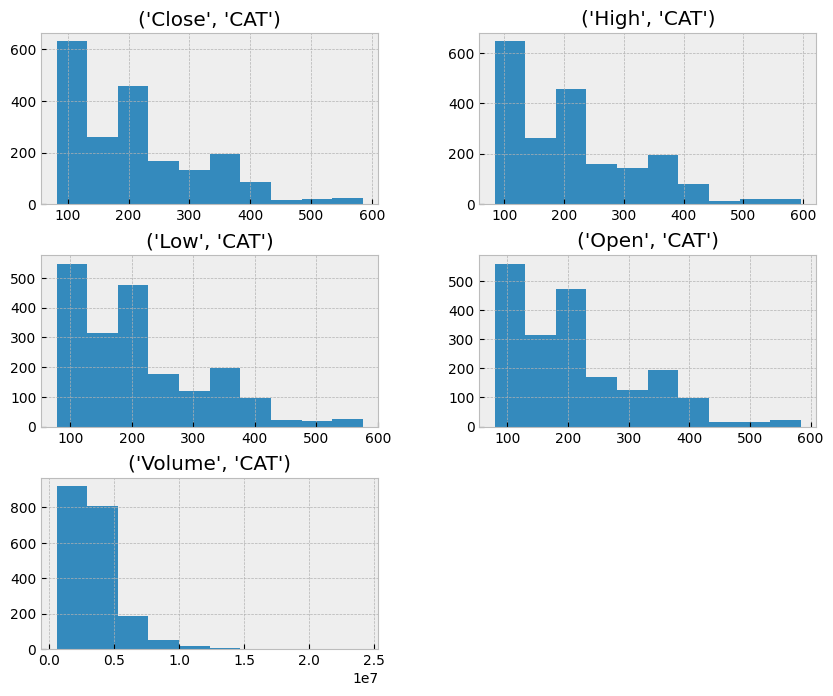

In [54]:
#visualize all distribution of dataset
df.hist(figsize = (10,8))
plt.show()

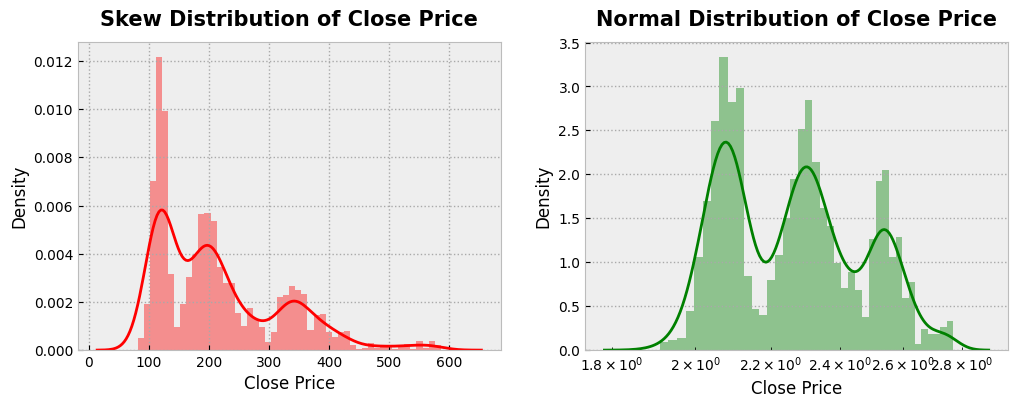

In [55]:
#transform skew distribution to normal distribution of close price
f = plt.figure(figsize = (12,4))

ax = f.add_subplot(121)
sns.distplot(df['Close'], bins = 50, color = 'r', ax = ax)
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.set_title('Skew Distribution of Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Close Price', fontsize = 12)
ax.set_ylabel('Density', fontsize = 12)

ax = f.add_subplot(122)
sns.distplot(np.log10(df['Close']), bins = 40, color = 'g', ax = ax)
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.set_title('Normal Distribution of Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Close Price', fontsize = 12)
ax.set_ylabel('Density', fontsize = 12)
ax.set_xscale('log')

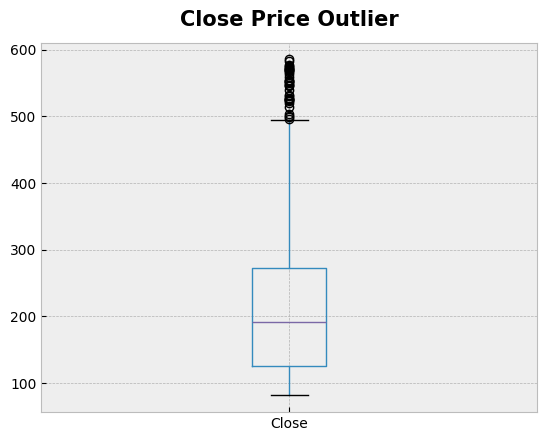

Maximum of Close Price : Ticker
CAT    585.48999
dtype: float64
Median of Close Price : Ticker
CAT    191.989365
dtype: float64
Minimum of Close Price : Ticker
CAT    81.646004
dtype: float64


In [56]:
#check outlier
df.boxplot(column = 'Close')
plt.title('Close Price Outlier', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

print('Maximum of Close Price :', df['Close'].max())
print('Median of Close Price :', df['Close'].median())
print('Minimum of Close Price :', df['Close'].min())

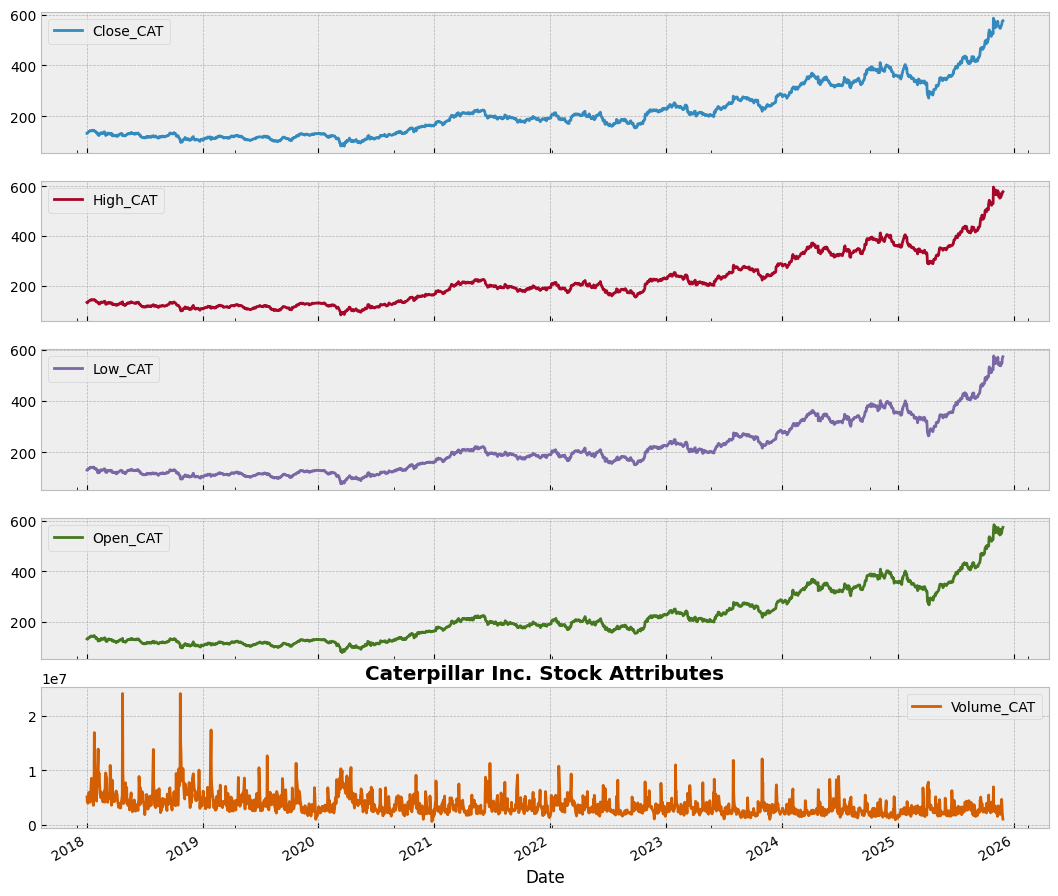

In [57]:
#visualize of each attribute columns
# Flatten the MultiIndex columns for easier plotting
df.columns = df.columns.map(lambda x: '_'.join(str(i) for i in x) if isinstance(x, tuple) else str(x))
df['2018':'2025'].plot(subplots = True, figsize = (13,12))
plt.title('Caterpillar Inc. Stock Attributes', fontweight = 'bold')
plt.show()

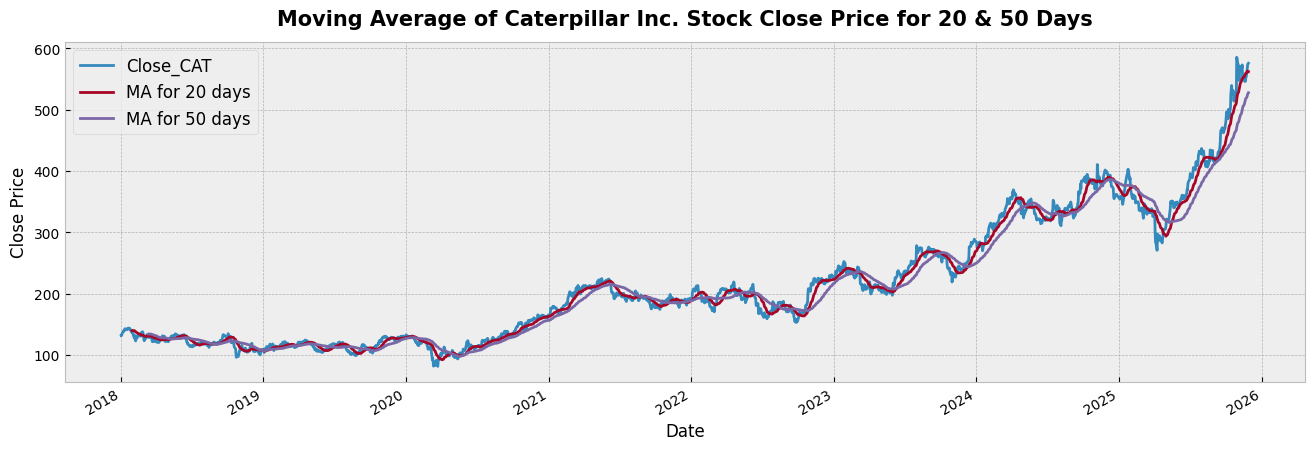

In [58]:
#check moving average
df['MA for 20 days'] = df['Close_CAT'].rolling(20).mean()
df['MA for 50 days'] = df['Close_CAT'].rolling(50).mean()

#visualize moving average
df.truncate(before = '2018-01-01', after = '2025-11-30')[['Close_CAT','MA for 20 days','MA for 50 days']].plot(
    subplots = False, figsize = (16,5))
plt.title('Moving Average of Caterpillar Inc. Stock Close Price for 20 & 50 Days', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price', fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

### Autoregressive Integrated Moving Average (ARIMA)

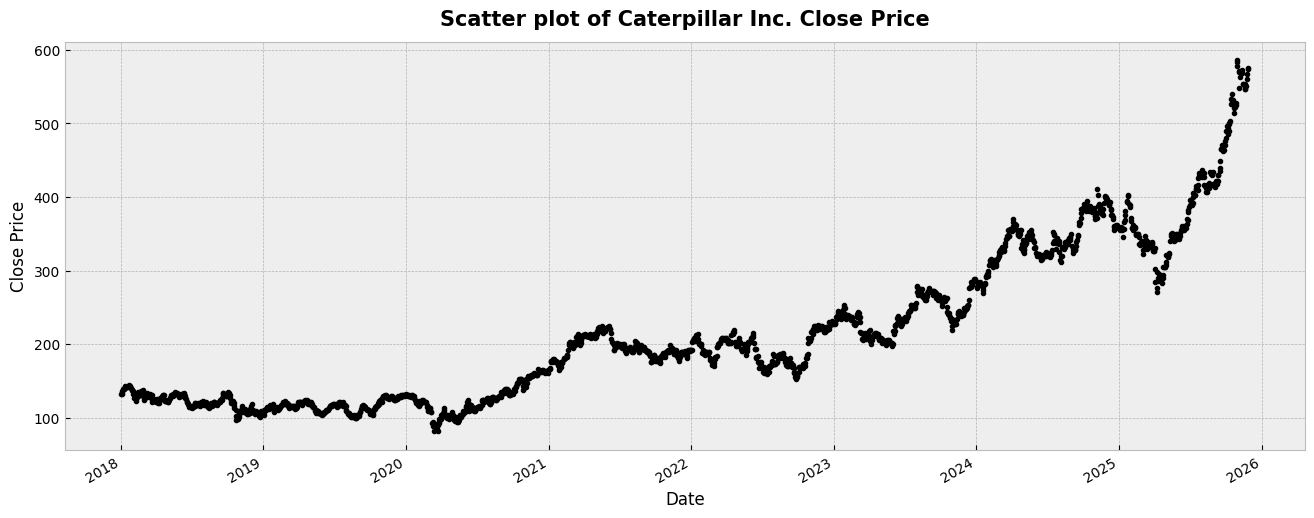

In [59]:
#visualize scatter plot of close price
df_close = df['Close_CAT']
df_close.plot(style = 'k.', figsize = (16,6))
plt.title('Scatter plot of Caterpillar Inc. Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price', fontsize = 12)
plt.show()

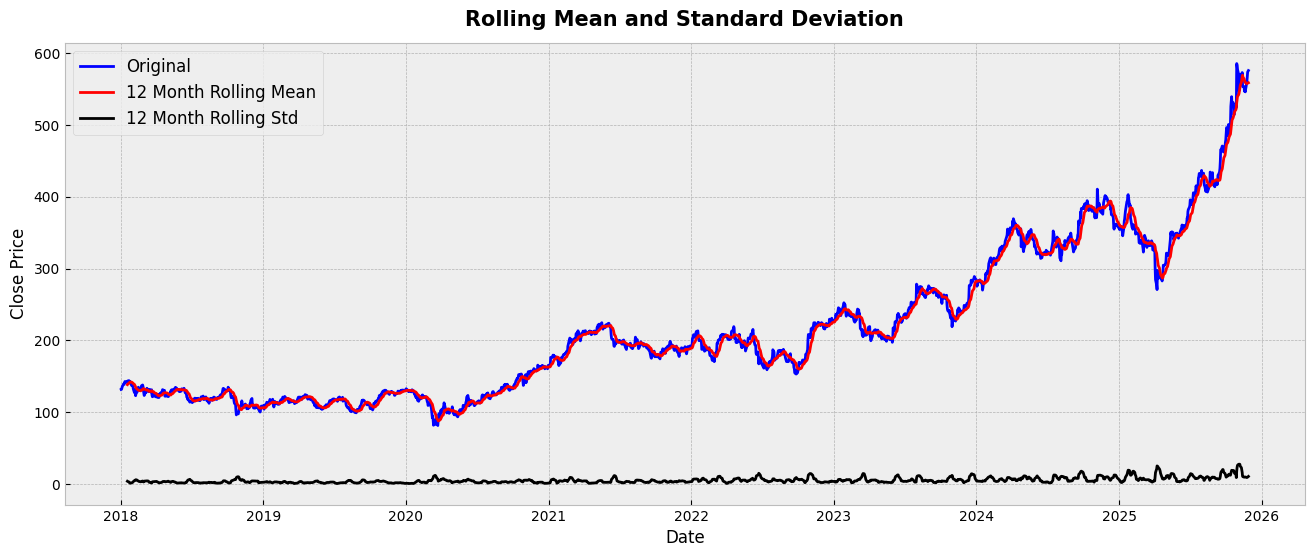

Results of dickey fuller test :
Test Statistics                   2.049944
p-value                           0.998734
No. of lags used                  0.000000
Number of observations used    1988.000000
critical value (1%)              -3.433644
critical value (5%)              -2.862995
critical value (10%)             -2.567545
dtype: float64


In [60]:
#check stationarity
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = '12 Month Rolling Mean')
    plt.plot(rolstd, color = 'black', label = '12 Month Rolling Std')
    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('Close Price', fontsize = 12)
    plt.legend(loc = 'best', fontsize = 12)
    plt.title('Rolling Mean and Standard Deviation', fontsize = 15, pad = 12, fontweight = 'bold')
    plt.show(block = False)

    print('Results of dickey fuller test :')
    adft = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(adft[0:4], index = ['Test Statistics','p-value','No. of lags used','Number of observations used'])

    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

#visualize rolling mean and standard deviation
plt.figure(figsize = (16,6))
test_stationarity(df_close)

<Figure size 800x400 with 0 Axes>

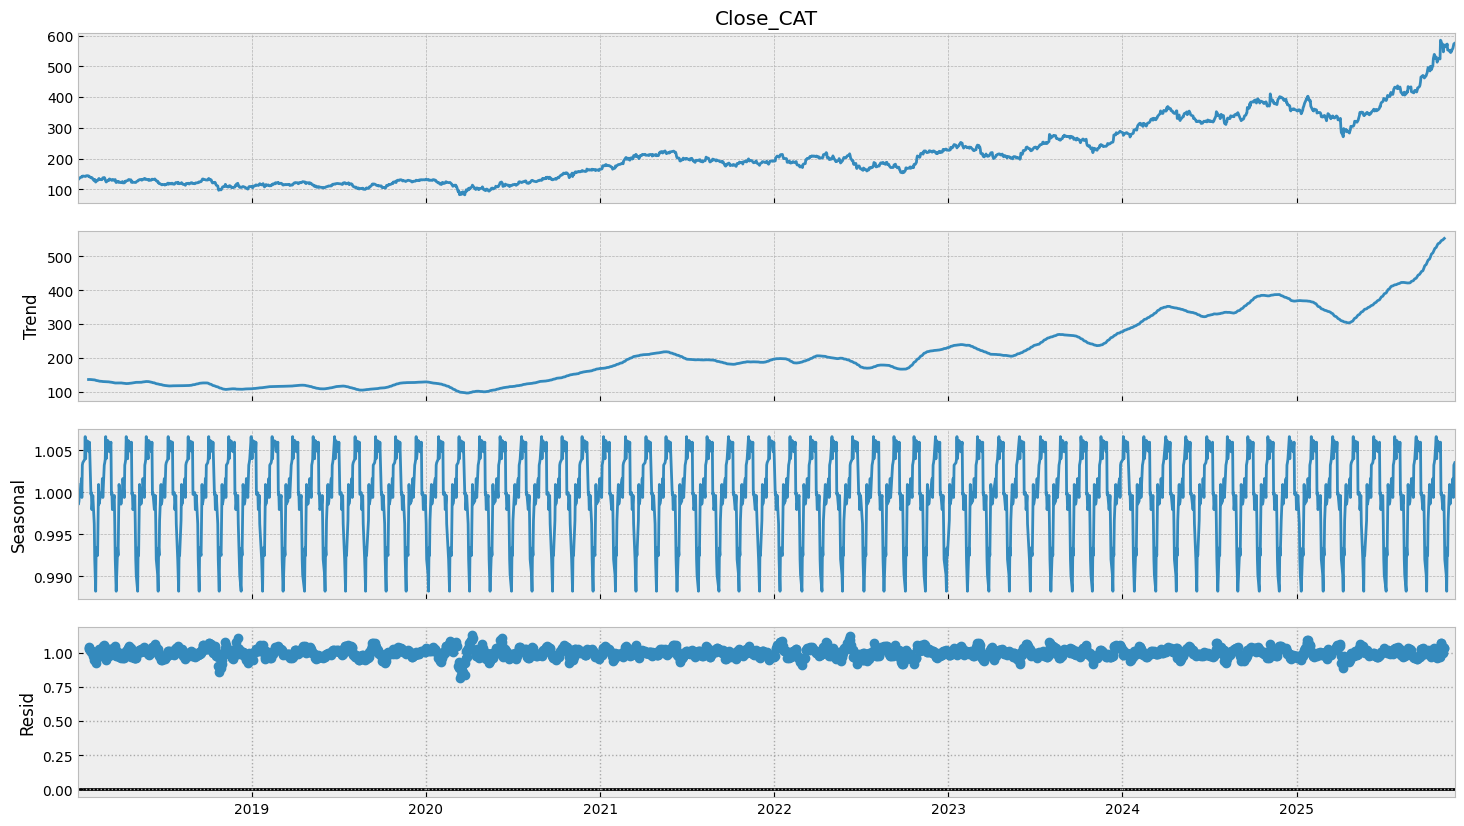

In [61]:
#visualize seasonal decomposition of close price
result = seasonal_decompose(df_close, model = 'multiplicative', period = 30)
fig = plt.figure(figsize = (8,4))
fig = result.plot()
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
fig.set_size_inches(16, 9)
fig.show()

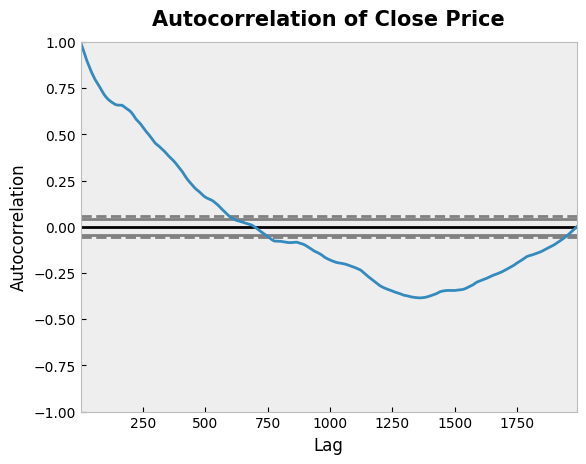

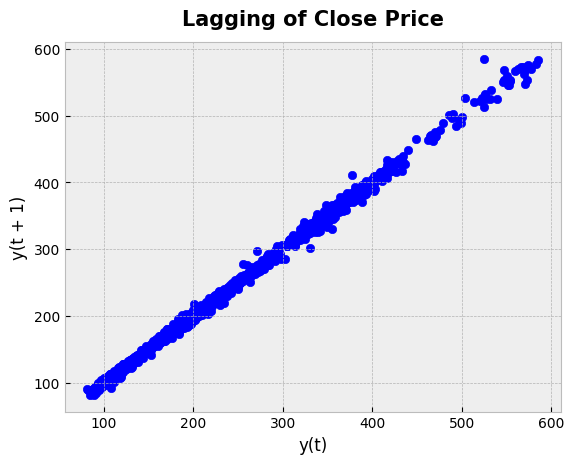

In [62]:
#visualize autocorrelation of close price
pd.plotting.autocorrelation_plot(df['Close_CAT'])
plt.title('Autocorrelation of Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

#visualize lagging of close price
pd.plotting.lag_plot(df['Close_CAT'])
plt.title('Lagging of Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

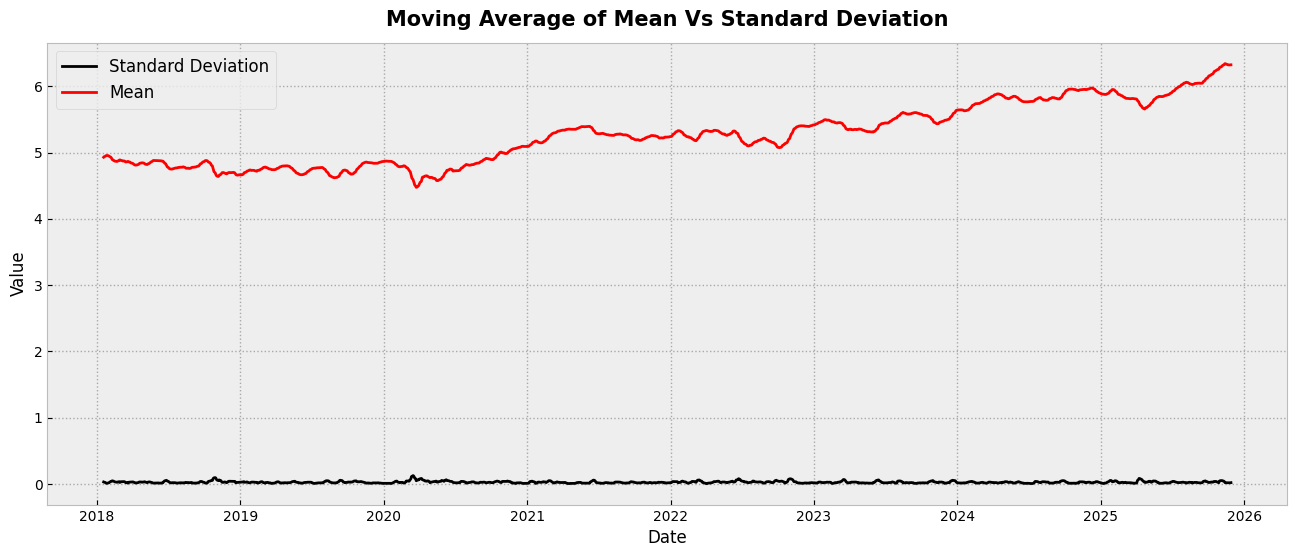

In [63]:
#visualize moving average based on standard deviation & mean
plt.figure(figsize = (16,6))
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc = 'best')
plt.title('Moving Average of Mean Vs Standard Deviation', fontsize = 15, pad = 12, fontweight = 'bold')
plt.plot(std_dev, color = 'black', label = 'Standard Deviation')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
plt.plot(moving_avg, color = 'red', label = 'Mean')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

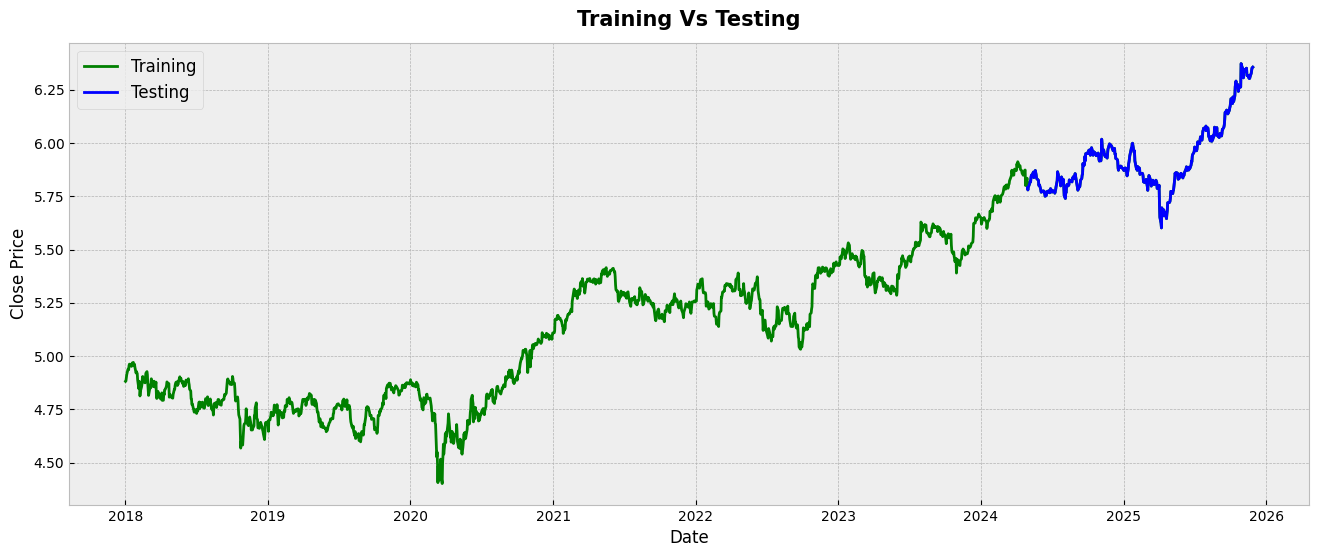

In [64]:
#visualize of training and testing set
train_data, test_data = df_log[3:int(len(df_log) * 0.8)], df_log[int(len(df_log) * 0.8):]
plt.figure(figsize = (16,6))
plt.grid(True)
plt.title('Training Vs Testing', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price', fontsize = 12)
plt.plot(df_log, 'green', label = 'Training')
plt.plot(test_data, 'blue', label = 'Testing')
plt.legend(fontsize = 12)
plt.show()

In [65]:
#build auto arima model for discover the optimal order in arima model
model_autoARIMA = auto_arima(train_data, trace = True, suppress_warnings = True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7838.440, Time=14.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7844.518, Time=0.79 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7842.567, Time=0.96 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7842.565, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7845.232, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7840.531, Time=1.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 18.151 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1588
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3923.616
Date:                Sun, 21 Dec 2025   AIC                          -7845.232
Time:                        12:56:28   BIC                          -7839.862
Sample:                             0   HQIC                         -7843.237
  

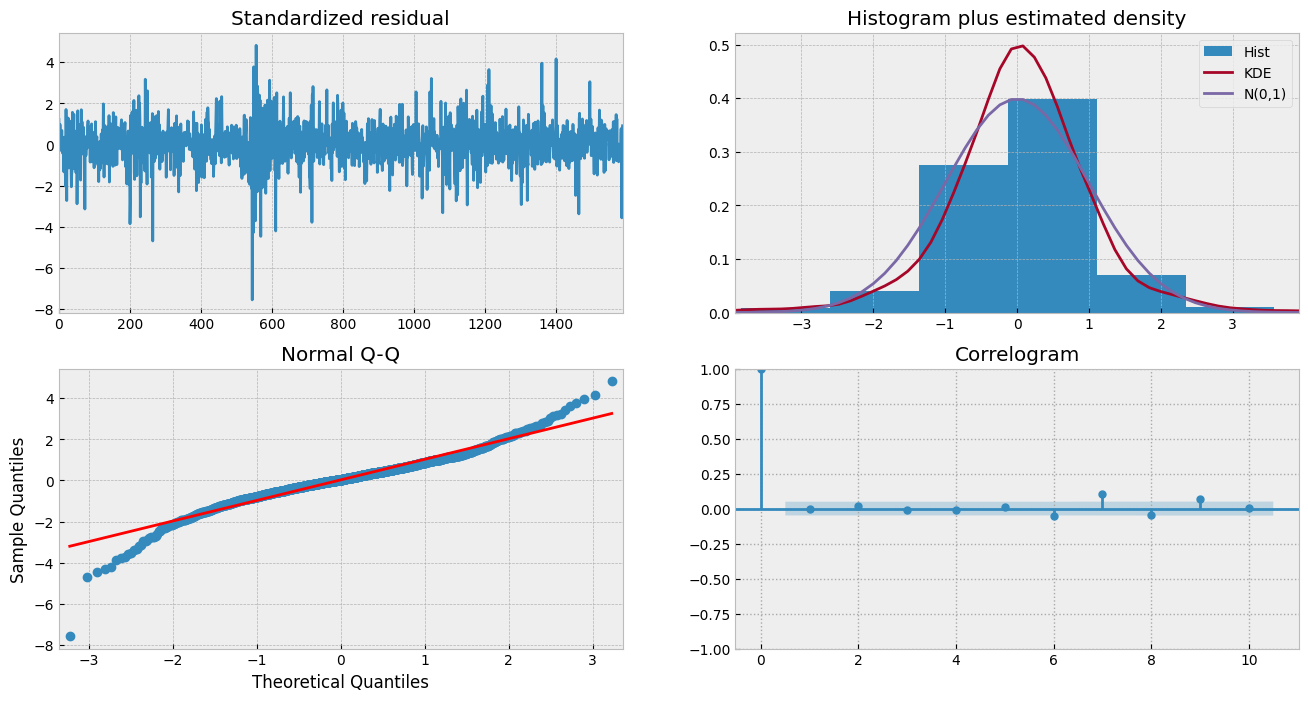

In [66]:
#visualize auto arima model
model_autoARIMA.plot_diagnostics(figsize = (16,8))
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
plt.show()

In [67]:
#build model
model = ARIMA(train_data, order = (0,1,0)) # Corrected order to (0,1,0) based on auto_arima
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Close_CAT   No. Observations:                 1588
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3923.616
Date:                Sun, 21 Dec 2025   AIC                          -7845.232
Time:                        12:56:32   BIC                          -7839.862
Sample:                             0   HQIC                         -7843.237
                               - 1588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   8.31e-06     50.153      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1328.96
Prob(Q):                              0.82   Pr

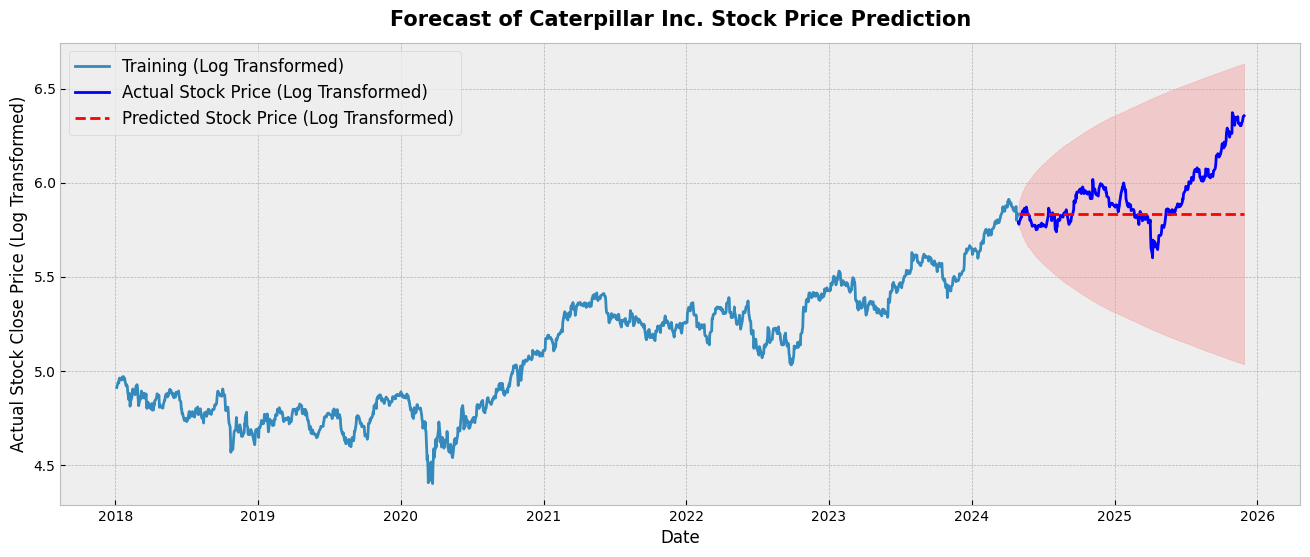

In [76]:
# Forecast
forecast_results = fitted.get_forecast(steps=len(test_data))
fc = forecast_results.predicted_mean
conf = forecast_results.conf_int(alpha=0.05)

plt.figure(figsize=(16,6))

# Training
plt.plot(
    train_data.index,
    train_data.values,
    label='Training (Log Transformed)'
)

# Actual
plt.plot(
    test_data.index,
    test_data.values,
    color='blue',
    label='Actual Stock Price (Log Transformed)'
)

# 🔴 Predicted
plt.plot(
    test_data.index,
    fc.values,
    color='red',
    linewidth=2,
    linestyle='--',
    label='Predicted Stock Price (Log Transformed)'
)

# Confidence interval
plt.fill_between(
    test_data.index,
    conf.iloc[:, 0].values,
    conf.iloc[:, 1].values,
    color='red',
    alpha=0.15
)

plt.title(
    'Forecast of Caterpillar Inc. Stock Price Prediction',
    fontsize=15,
    pad=12,
    fontweight='bold'
)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Actual Stock Close Price (Log Transformed)', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [77]:
#check performance
mse = metrics.mean_squared_error(test_data, fc)
print('Mean Squared Error : '+str(mse))
mae = metrics.mean_absolute_error(test_data, fc)
print('Mean Absolute Error : '+str(mae))
rmse = math.sqrt(metrics.mean_squared_error(test_data, fc))
print('Root Mean Squared Error : '+str(rmse))
mape = np.mean(np.abs(fc - test_data) / np.abs(test_data))
print('Mean Absolute Percentage Error : '+str(mape))

Mean Squared Error : 0.034794628880710075
Mean Absolute Error : 0.12983939695903718
Root Mean Squared Error : 0.18653318439545838
Mean Absolute Percentage Error : nan


### Linear Regression

In [82]:
#split data
X = df[['High_CAT', 'Low_CAT', 'Open_CAT', 'Volume_CAT']]
y = df['Close_CAT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1392, 4)
(1392,)
(597, 4)
(597,)


In [83]:
#build linear regression model
lr = LinearRegression()
%time lr.fit(X_train, y_train)
print('Training Accuracy Score : {}'.format(lr.score(X_train, y_train)))
print('Testing Accuracy Score : {}'.format(lr.score(X_test, y_test)))

CPU times: user 4.46 ms, sys: 0 ns, total: 4.46 ms
Wall time: 4.72 ms
Training Accuracy Score : 0.9997965456772179
Testing Accuracy Score : 0.9997664914195235


In [84]:
#prediction
y_pred = lr.predict(X_test)
print(y_pred)

[232.51918364 203.27591443 187.79596863 131.81772826 324.96315397
 152.05922591 463.97401068 340.01080784 279.21023569 136.10493364
 287.02244252 131.68368559 315.41089764 202.80914387 384.80190649
 201.80166063 175.63844399 105.43667228 162.10193061 121.99971934
 411.78127953 202.71423541 199.54173073 326.78318445 121.43088795
 174.76006808 194.48118264 185.63146819 183.35519713 123.55201806
 194.68060422 121.12514744 166.86358877 393.66858422 110.88316271
 306.90143352 349.45400405 193.5237126  112.56387769 144.50801696
 123.34927675 206.92292067 209.66816815 139.9832856  198.16079443
 131.58098011 128.73954677 209.10725727 119.29715945 165.50375225
 115.34182525 111.23615083 130.32058697 320.05803515 179.48359876
 169.70579407 227.44266587 114.20929693 349.01265815 317.20732731
 129.35084627 117.44559366 114.69520209 178.42399131 131.42449837
 120.09840835 239.83816494 252.09278592 228.52268963 108.55696292
 211.42720615 202.04084689 114.62723934 266.77273553 220.39683977
 334.43220

In [86]:
#check MAE, MSE, RMSE & R2 score
mae = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error : {}'.format(mae * 0.1))
mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error : {}'.format(mse * 0.01))
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error : {}'.format(rmse * 0.1))
r2_score = round(metrics.r2_score(y_test, y_pred), 2)
print('R2 Score : {}'.format(r2_score))

Mean Absolute Error : 0.1084480584467076
Mean Squared Error : 0.023865497994492505
Root Mean Squared Error : 0.15448462057594117
R2 Score : 1.0


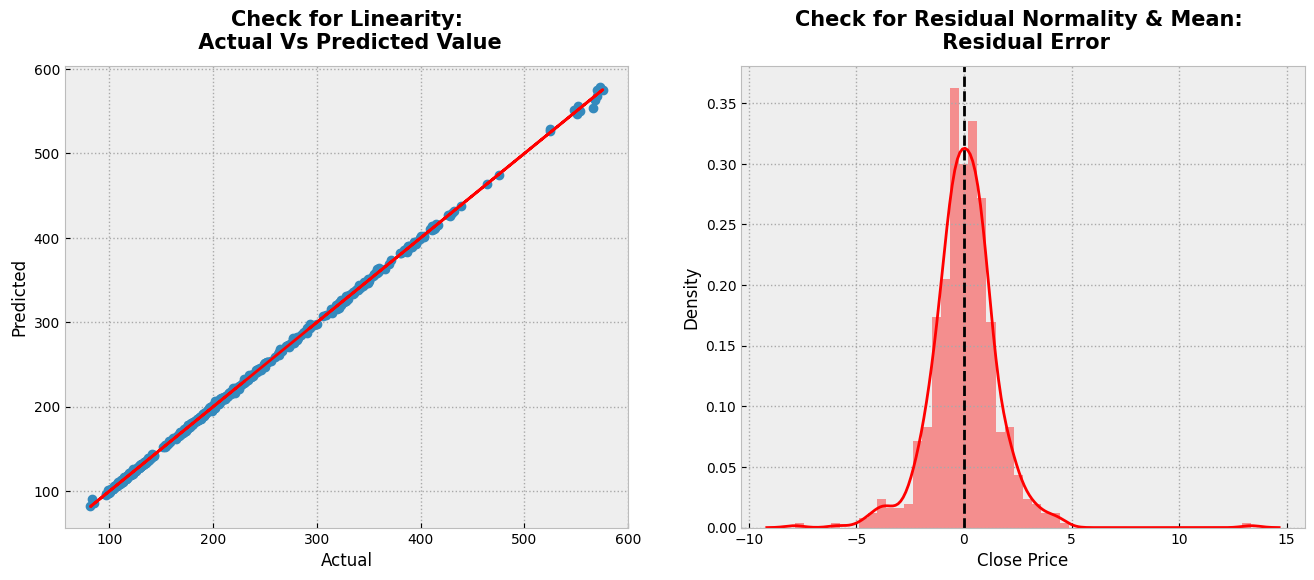

In [87]:
f = plt.figure(figsize = (16,6))

#check for linearity
ax = f.add_subplot(121)
plt.plot(y_test, y_pred, 'o')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color = 'r')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.set_title('Check for Linearity:\n Actual Vs Predicted Value', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Actual', fontsize = 12)
ax.set_ylabel('Predicted', fontsize = 12)

#check for residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred), ax = ax, color = 'r')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.axvline((y_test - y_pred).mean(), color = 'k', linestyle = '--')
ax.set_title('Check for Residual Normality & Mean: \n Residual Error', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Close Price', fontsize = 12)
ax.set_ylabel('Density', fontsize = 12)
plt.show()

In [88]:
#prediction of linear regression for forecast 360 days ahead
num = 360
X_Predict = X[-num:]
Forecast = lr.predict(X_Predict)
print(Forecast)

[318.9904223  318.12793041 320.09172785 325.59512764 320.30324059
 320.35944126 323.24048828 321.76971866 322.6749268  320.26411336
 317.20732731 325.46367415 328.76781989 337.32029308 349.82271328
 351.65692776 357.76637998 341.66667856 337.05215757 338.23692189
 332.31570309 337.9530316  344.12571421 339.20875416 335.00246259
 339.87179948 328.74513681 313.44351773 310.83639526 319.65583016
 321.71368718 327.01943719 328.97466413 329.63545218 330.05547009
 331.13525162 337.72938442 335.86361479 338.86873653 337.02738588
 336.84057475 337.32651981 340.63835652 346.17851925 342.36816202
 343.38561971 345.87340303 346.77804704 335.47390096 331.54272399
 325.97454847 326.78318445 328.88144775 324.98870715 323.45410201
 332.26346439 338.19798053 341.15358586 346.44825268 351.47453449
 364.05502995 360.96465408 363.67822968 379.92233662 374.15085809
 385.49359237 385.85029307 382.79444414 383.70638231 384.96377468
 383.54151186 386.16486687 392.48688367 380.31671543 386.94402474
 385.59107

In [89]:
#check last date for forecasting
date = np.array(df.index)
last_date = date[len(date) - 1]
print(last_date)

2025-11-28T00:00:00.000000000


In [91]:
#create timeseries from the last date
time = pd.date_range('2025-11-28', periods = num, freq = 'd')
time

DatetimeIndex(['2025-11-28', '2025-11-29', '2025-11-30', '2025-12-01',
               '2025-12-02', '2025-12-03', '2025-12-04', '2025-12-05',
               '2025-12-06', '2025-12-07',
               ...
               '2026-11-13', '2026-11-14', '2026-11-15', '2026-11-16',
               '2026-11-17', '2026-11-18', '2026-11-19', '2026-11-20',
               '2026-11-21', '2026-11-22'],
              dtype='datetime64[ns]', length=360, freq='D')

In [92]:
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']
df_predict.head()

,Forecast
2025-11-28,318.990422
2025-11-29,318.127930
2025-11-30,320.091728
2025-12-01,325.595128
2025-12-02,320.303241


In [93]:
#joining dataframe moderna & prediction result
df_result = pd.concat([df, df_predict], axis = 1)
df_result.tail(num)

,Close_CAT,High_CAT,Low_CAT,Open_CAT,Volume_CAT,MA for 20 days,MA for 50 days,Forecast
2025-11-28,575.76001,577.359985,572.400024,573.789978,1019500.0,562.057001,527.640703,318.990422
2025-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,318.127930
2025-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.091728
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.595128
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.303241
...,...,...,...,...,...,...,...,...
2026-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,546.157099
2026-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,561.700462
2026-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,553.248236
2026-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,572.529421


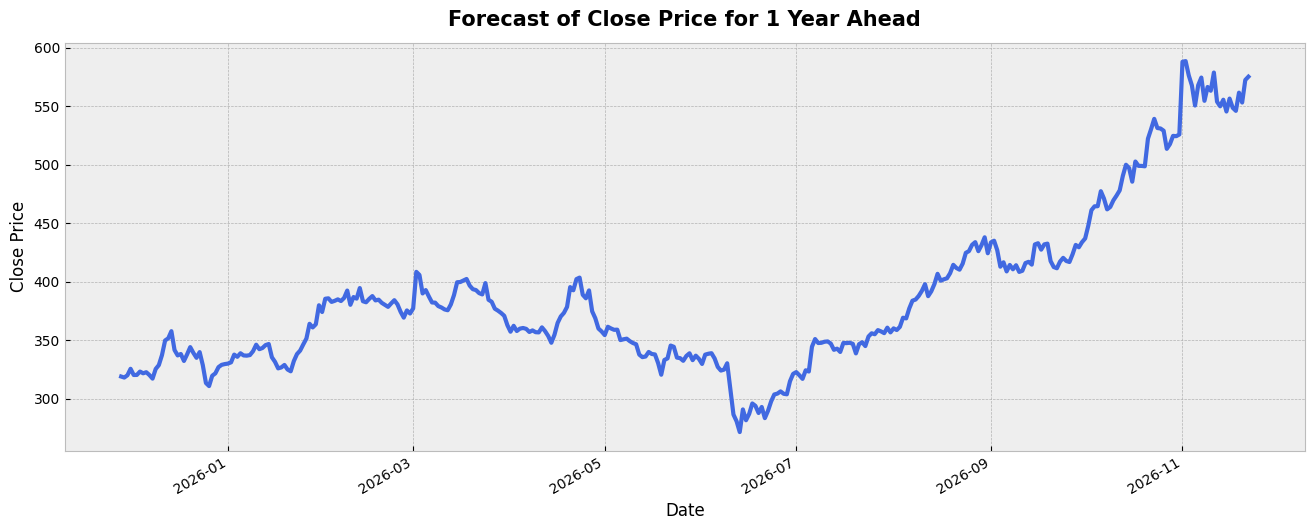

In [94]:
#visualize forecast prediction from close price
plt.figure(figsize = (16,6))
df_result['Forecast'].plot(color = 'royalblue', linewidth = 3)
plt.title('Forecast of Close Price for 1 Year Ahead', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price', fontsize = 12)
plt.show()